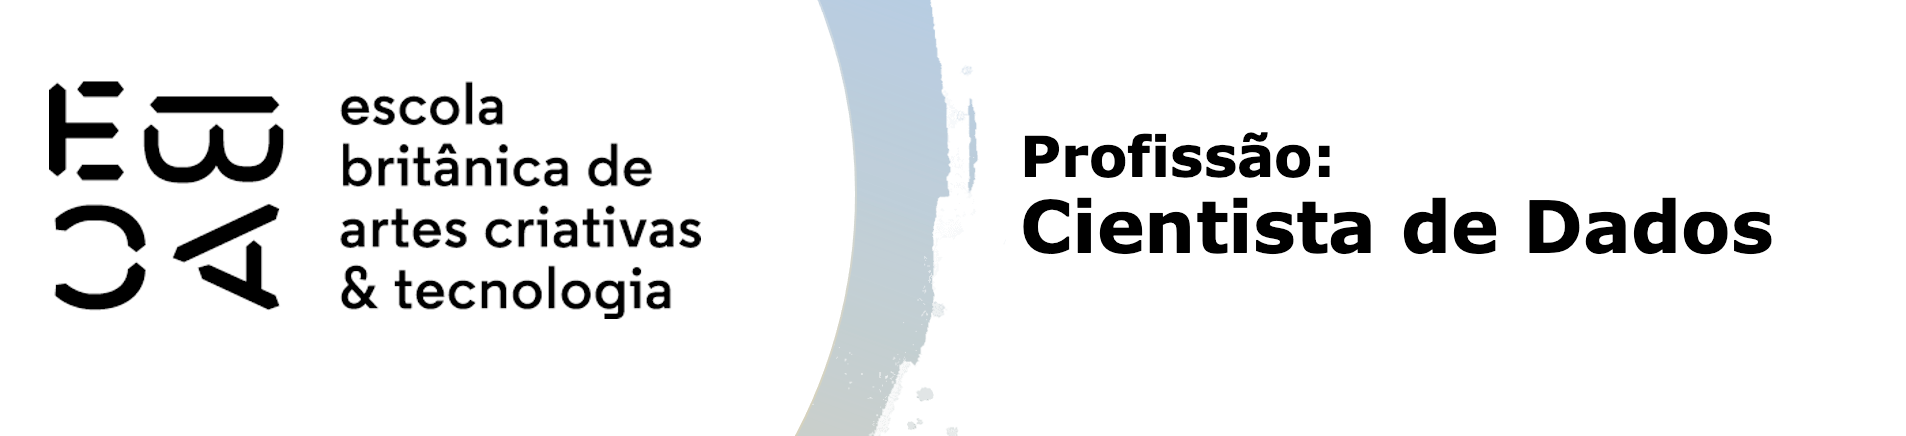

# Tarefa II

Continuaremos utlizando a mesma base:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

Vamos iniciar importndo os pacotes e carregando a base:

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
#carregamento e exibição da base:
df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


Veficiando e tratando os valores ausentes:

In [58]:
df.isna().sum()

CNPJ emit.               0
Emitente                 0
No.                      0
Data Emissão             0
Valor NF                 0
Data Registro            0
Créditos                 0
Situação do Crédito      0
Ano                      0
Semestre                 0
Retorno                980
flag_credito             0
categoria                0
dtype: int64

In [59]:
# Substituindo NaN por 0 na coluna 'Retorno'
df['Retorno'] = df['Retorno'].fillna(0)
df.isna().sum()

CNPJ emit.             0
Emitente               0
No.                    0
Data Emissão           0
Valor NF               0
Data Registro          0
Créditos               0
Situação do Crédito    0
Ano                    0
Semestre               0
Retorno                0
flag_credito           0
categoria              0
dtype: int64

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Criação das categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [61]:
# Criando as variáveis temporais no novo DataFrame
df['Dia da Semana'] = df['Data Emissão'].dt.day_name()
df['Dummy Fim de Semana'] = df['Data Emissão'].dt.weekday.isin([5, 6]).astype(int)
df['Dia do Mês'] = df['Data Emissão'].dt.day
df['Trimestre'] = df['Data Emissão'].dt.quarter
df['Mês'] = df['Data Emissão'].dt.month
# Exibindo o resultado
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,Dia da Semana,Dummy Fim de Semana,Dia do Mês,Trimestre,Mês
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado,Friday,0,30,2,6
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto,Friday,0,30,2,6
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes,Friday,0,30,2,6
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes,Friday,0,30,2,6
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes,Friday,0,30,2,6


In [62]:
# Criando categorias por quantis:
df['Valor-NF-cat-5'] = pd.qcut(df['Valor NF'], q=5, labels=False)  # 5 categorias
df['Valor-NF-cat-10'] = pd.qcut(df['Valor NF'], q=10, labels=False)  # 10 categorias
df['Valor-NF-cat-20'] = pd.qcut(df['Valor NF'], q=20, labels=False, duplicates='drop')  # 20 categorias
df['Valor-NF-cat-50'] = pd.qcut(df['Valor NF'], q=50, labels=False, duplicates='drop')  # 50 categorias
# Exibindo o resultado:
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,categoria,Dia da Semana,Dummy Fim de Semana,Dia do Mês,Trimestre,Mês,Valor-NF-cat-5,Valor-NF-cat-10,Valor-NF-cat-20,Valor-NF-cat-50
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,...,Mercado,Friday,0,30,2,6,1,3,7,17
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,...,Auto posto,Friday,0,30,2,6,2,5,11,28
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,...,Restaurantes,Friday,0,30,2,6,1,3,7,19
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,...,Restaurantes,Friday,0,30,2,6,3,7,15,38
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,...,Restaurantes,Friday,0,30,2,6,3,7,15,39


## Calculo o IV (Informatin Value) das variáveis

Sugestão: Construíremos um metadados e utilizaremos uma função que para agilizar o cálculo de todas as variáveis.

O Information Value pode ser calculado para variáveis categóricas, numéricas e dummies, por isso, vamos começar observando quais os tipos de variáveis que dispomos:

In [64]:
metadados = pd.DataFrame({'dtype':df.dtypes})
metadados

,dtype
CNPJ emit.,object
Emitente,object
No.,int64
Data Emissão,datetime64[ns]
Valor NF,float64
Data Registro,datetime64[ns]
Créditos,float64
Situação do Crédito,category
Ano,int64
Semestre,int64


Observando o dataframe acima, podemos visualizar algumas colunas que não possuem poder preditivo, como é o caso do CNPJ, do Emitente, da Data de Registro e do número da nota fiscal. 

A seguir, vamos exlcuir algumas dessas variáveis do nosso metadados: 

In [66]:
# Excluindo algumas variaveis pela linha
metadados = metadados.drop(['CNPJ emit.', 'Emitente', 'No.', 'Data Emissão', 'Data Registro', 'Situação do Crédito'], axis=0)
metadados

,dtype
Valor NF,float64
Créditos,float64
Ano,int64
Semestre,int64
Retorno,float64
flag_credito,int64
categoria,object
Dia da Semana,object
Dummy Fim de Semana,int32
Dia do Mês,int32


Agora, vamos definir quais são as nossas covariáveis e qual é a nossa variável resposta e realizar a contagem de quantos valores unicos temos para cada variável:

In [68]:
#cria coluna papel e para todas as linhas recebe covariável:
metadados['papel'] = 'covariavel'
#encontra a flag_credito e troca o papel dela para resposta:
metadados.loc['flag_credito','papel'] = 'resposta'
#contagem de valores únicos:
metadados['nunique'] = df.nunique()
#exibindo:
metadados

,dtype,papel,nunique
Valor NF,float64,covariavel,33658
Créditos,float64,covariavel,9717
Ano,int64,covariavel,5
Semestre,int64,covariavel,2
Retorno,float64,covariavel,60202
flag_credito,int64,resposta,2
categoria,object,covariavel,9
Dia da Semana,object,covariavel,7
Dummy Fim de Semana,int32,covariavel,2
Dia do Mês,int32,covariavel,31


Agora, iremos utilizar uma função para fazer o cálculo do IV (Information Value) para todas as variáveis:

*Obs: Para algumas variáveis não será possível realizar o cálculo, uma vez que o information value funciona melhor para variáveis que possuem **nunique()-valores únicos** menores dos que os mostrados para as variáveis Valor NF, Creditos e Retorno.*

In [70]:
def calcular_iv_todas(metadados, df, resposta_col):

    # Função para calcular o IV de uma única variável
    def IV(variavel, resposta):
        tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')
        rótulo_evento = tab.columns[0]
        rótulo_nao_evento = tab.columns[1]
        tab['pct_evento'] = tab[rótulo_evento] / tab.loc['total', rótulo_evento]
        tab['pct_nao_evento'] = tab[rótulo_nao_evento] / tab.loc['total', rótulo_nao_evento]
        tab['woe'] = np.log(tab.pct_evento / tab.pct_nao_evento)
        tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento) * tab.woe
        return tab['iv_parcial'].sum()

    # Inicializar a coluna de IV
    metadados['IV'] = np.nan

    # Iterar sobre as variáveis em metadados
    for var in metadados.index:
        try:
            if var != resposta_col and var in df.columns:
                metadados.loc[var, 'IV'] = IV(df[var], df[resposta_col])
        except Exception as e:
            print(f"Erro ao calcular IV para {var}: {e}")

    return metadados

In [71]:
# Calcular IV para todas as variáveis:
metadados = calcular_iv_todas(metadados, df, resposta_col='flag_credito')

# Visualizar os resultados
metadados

C:\Users\charl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\charl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\charl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,dtype,papel,nunique,IV
Valor NF,float64,covariavel,33658,inf
Créditos,float64,covariavel,9717,inf
Ano,int64,covariavel,5,0.041651
Semestre,int64,covariavel,2,0.001258
Retorno,float64,covariavel,60202,inf
flag_credito,int64,resposta,2,NaN
categoria,object,covariavel,9,0.408313
Dia da Semana,object,covariavel,7,0.006883
Dummy Fim de Semana,int32,covariavel,2,0.004346
Dia do Mês,int32,covariavel,31,0.043719


### Conclusão: 
*Podemos dizer aqui que temos 2 variáveis com poder de discriminação, sendo elas* ***<span style="color:red;">categoria</span>***, *que é de fato a com maior poder preditivo, seguida de* ***<span style="color:red;">Valor NF</span>***, *essa, quanto maior o número de categorias, maior o potencial preditivo.*



## Descritiva simples no tempo

Para compor a análise que virá a seguir, faremos uma análise descritiva básica no tempo - utilizaremos trimestre como agregação e avaliaremos graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

#### Quantidade de Notas Regristradas por Trimestre:

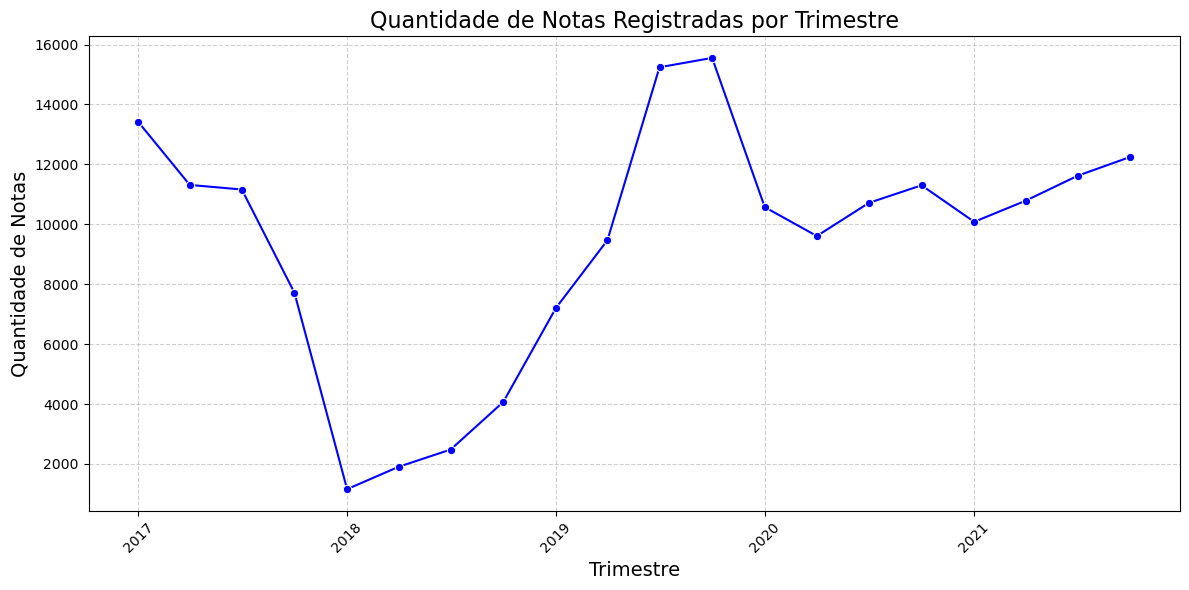

In [75]:
# Criando a coluna 'Ano_Trimestre' combinando 'Ano' e 'Trimestre'
df['Ano_Trimestre'] = df['Ano'].astype(str) + '-Q' + df['Trimestre'].astype(str)

# Agrupando pelo trimestre e contando a quantidade de notas
notas_por_trimestre = df.groupby('Ano_Trimestre').size().reset_index(name='Quantidade_Notas')

# Convertendo 'Ano_Trimestre' para um tipo datetime para facilitar a plotagem
notas_por_trimestre['Ano_Trimestre'] = pd.PeriodIndex(notas_por_trimestre['Ano_Trimestre'], freq='Q').to_timestamp()

# Configurando o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=notas_por_trimestre, x='Ano_Trimestre', y='Quantidade_Notas', marker='o', color='b')
plt.title('Quantidade de Notas Registradas por Trimestre', fontsize=16)
plt.xlabel('Trimestre', fontsize=14)
plt.ylabel('Quantidade de Notas', fontsize=14)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Do primeiro trismestre de 2017 até 2018, houve uma queda brusca de notas registradas, somente a partir do segundo trimestre de 2018 que houve um aumento de notas registradas que perpetuou até o início do último trimestre de 2019. A partir de 2020 parece que temos ai valores mais estáveis. 

#### Quantidade de Notas por Categoria e Período:

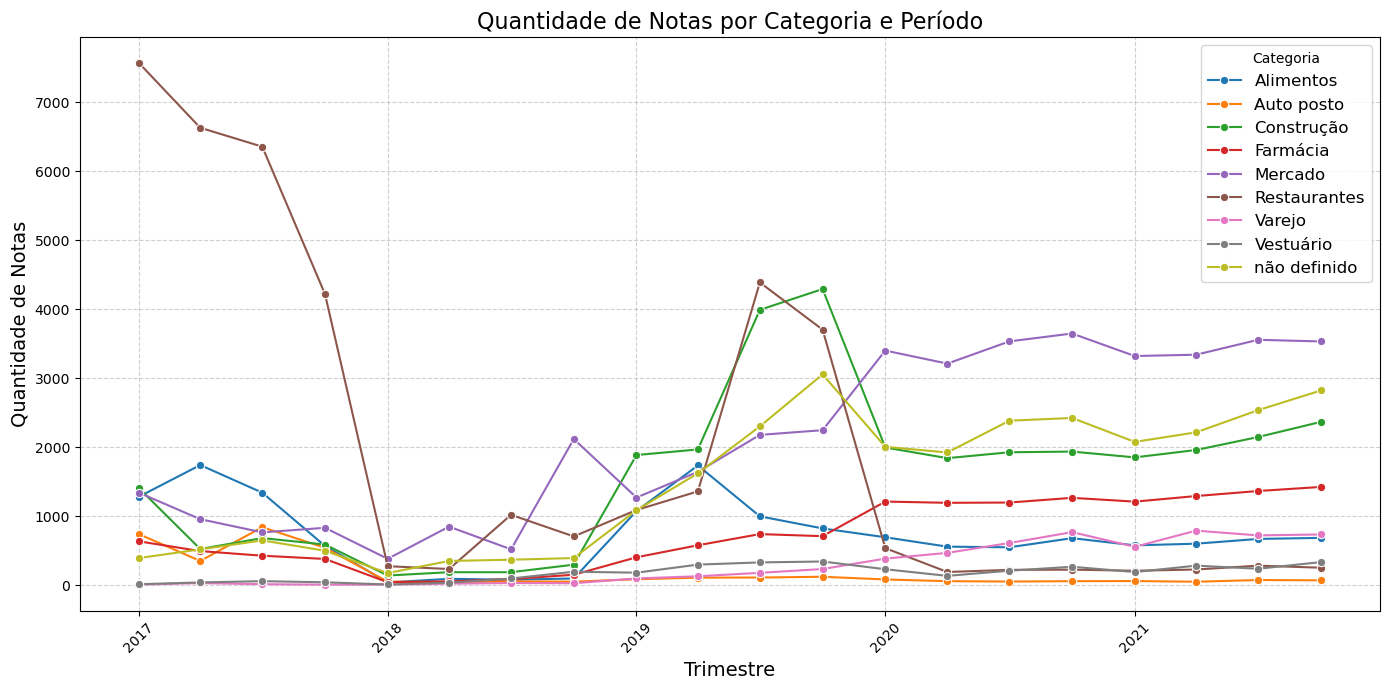

In [78]:
# Agrupando por categoria e período, contando a quantidade de notas
notas_por_categoria_periodo = (
    df.groupby(['Ano_Trimestre', 'categoria'])
    .size()
    .reset_index(name='Quantidade_Notas')
)

# Convertendo 'Ano_Trimestre' para um tipo datetime para facilitar a plotagem
notas_por_categoria_periodo['Ano_Trimestre'] = pd.PeriodIndex(notas_por_categoria_periodo['Ano_Trimestre'], freq='Q').to_timestamp()

# Configurando o gráfico
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=notas_por_categoria_periodo,
    x='Ano_Trimestre',
    y='Quantidade_Notas',
    hue='categoria',
    marker='o'
)

# Ajustando os detalhes do gráfico
plt.title('Quantidade de Notas por Categoria e Período', fontsize=16)
plt.xlabel('Trimestre', fontsize=14)
plt.ylabel('Quantidade de Notas', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Categoria', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

A quantidade de notas registradas por categorias, nos mostram um comportamento mais instável para a categoria restaurante, que tinha uma quantidade muito alta no primeiro trimestre de 2017 e houve uma queda bruca até a chegada de 2018. Após isso houveram mais algumas instabilidades que  caminharam para um aumento considerável para o terceiro trimestre de 2019 e posteriormente novamente queda até o segundo trimestre de 2020 em que aparentemente houve uma estabilização. 

Já a categoria mercado mostra uma caminhada de aumentos até 2020 que depois se estabilizou. 

Algumas categorias já eram estáveis antes de 2020, mas a partir de 2020 é visível que todas passaram a ser mais estáveis. 

#### Proporção de Notas com Crédito por Categoria e Período:

C:\Users\charl\AppData\Local\Temp\ipykernel_11332\4029966339.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['flag_credito'] == 1).mean())


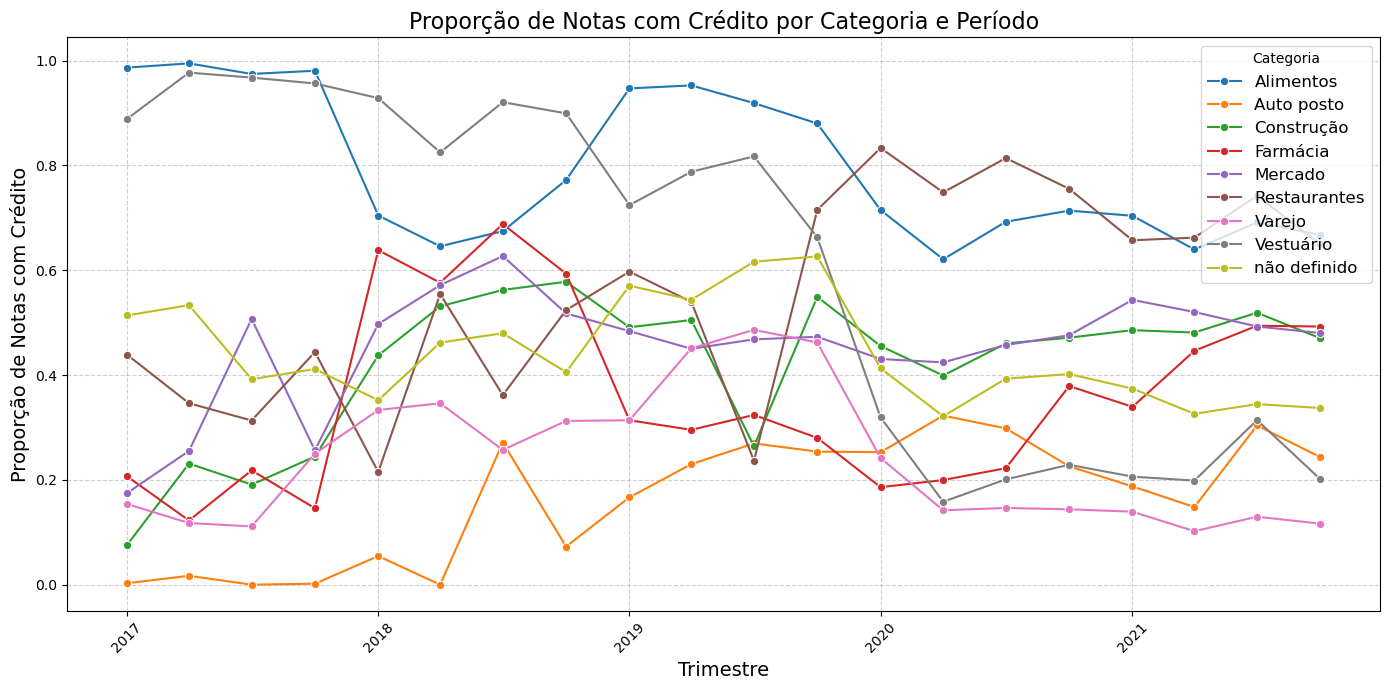

In [81]:
# Agrupando por categoria e período, calculando a proporção de notas com crédito
proporcao_credito_categoria_periodo = (
    df.groupby(['Ano_Trimestre', 'categoria'])
    .apply(lambda x: (x['flag_credito'] == 1).mean())
    .reset_index(name='Proporcao_Credito')
)

# Convertendo 'Ano_Trimestre' para um tipo datetime para facilitar a plotagem
proporcao_credito_categoria_periodo['Ano_Trimestre'] = pd.PeriodIndex(proporcao_credito_categoria_periodo['Ano_Trimestre'], freq='Q').to_timestamp()

# Configurando o gráfico
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=proporcao_credito_categoria_periodo,
    x='Ano_Trimestre',
    y='Proporcao_Credito',
    hue='categoria',
    marker='o'
)

# Ajustando os detalhes do gráfico
plt.title('Proporção de Notas com Crédito por Categoria e Período', fontsize=16)
plt.xlabel('Trimestre', fontsize=14)
plt.ylabel('Proporção de Notas com Crédito', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Categoria', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Como no gráfico anterior, a gente tem aqui algumas categorias com comportamento bem instáveis anterior ao ano de 2020, mas com uma maior estabilização após a chegada desse ano. 

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [84]:
def calcular_woe_iv(df, grupo, target):
    import numpy as np
    
    resumo = df.groupby(grupo).agg(
        Evento=(target, lambda x: (x == 1).sum()),
        Nao_evento=(target, lambda x: (x == 0).sum())
    )
    resumo['Total'] = resumo['Evento'] + resumo['Nao_evento']
    resumo['%Evento'] = resumo['Evento'] / resumo['Evento'].sum()
    resumo['%Nao_evento'] = resumo['Nao_evento'] / resumo['Nao_evento'].sum()
    resumo['WoE'] = np.log(resumo['%Evento'] / resumo['%Nao_evento'])
    resumo['IV'] = (resumo['%Evento'] - resumo['%Nao_evento']) * resumo['WoE']
    return resumo[['WoE', 'IV']].reset_index()

# Calcular o WoE e IV por 'Ano_Trimestre' e 'categoria'
woe_iv_por_tempo_categoria = calcular_woe_iv(df, ['Ano_Trimestre', 'categoria'], 'flag_credito')

# Separar apenas o WoE por período e categoria
woe_por_tempo_categoria = woe_iv_por_tempo_categoria[['Ano_Trimestre', 'categoria', 'WoE']]

# Agregar o IV por período e categoria
iv_por_tempo_categoria_agg = (
    iv_por_tempo_categoria.groupby(['Ano_Trimestre', 'categoria'])['IV']
    .sum()
    .reset_index()
)

C:\Users\charl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Information Value no Tempo por Categoria:

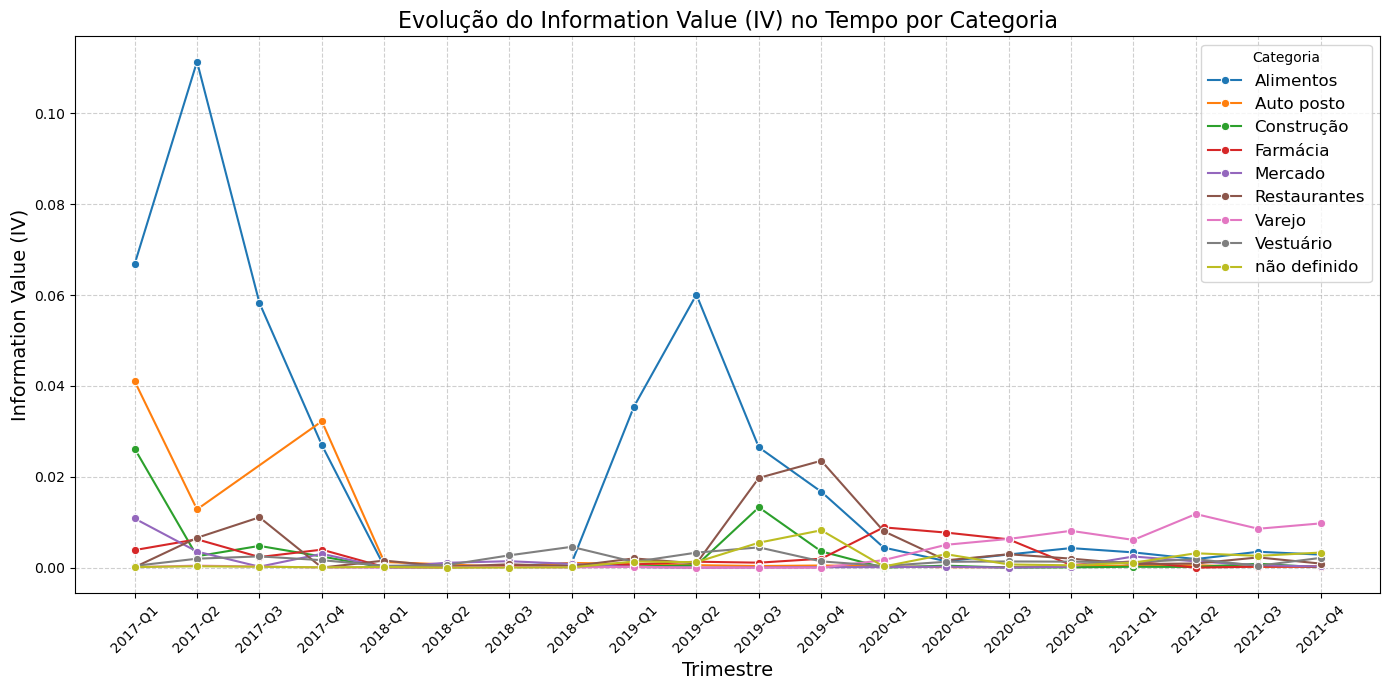

In [86]:
plt.figure(figsize=(14, 7))

# Plotar a evolução do IV ao longo do tempo por categoria
sns.lineplot(
    data=iv_por_tempo_categoria_agg,
    x='Ano_Trimestre',
    y='IV',
    hue='categoria',
    marker='o'
)

# Configurações do gráfico
plt.title('Evolução do Information Value (IV) no Tempo por Categoria', fontsize=16)
plt.xlabel('Trimestre', fontsize=14)
plt.ylabel('Information Value (IV)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Categoria', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


As categorias para as quais o IV mais oscilava antes de 2020 são Alimentos e Autoposto. Após 2020, já temos um comportamento mais estável para todas as categorias, incluindo essas duas. 

#### Weigth Of Evidence no Tempo por Categoria:

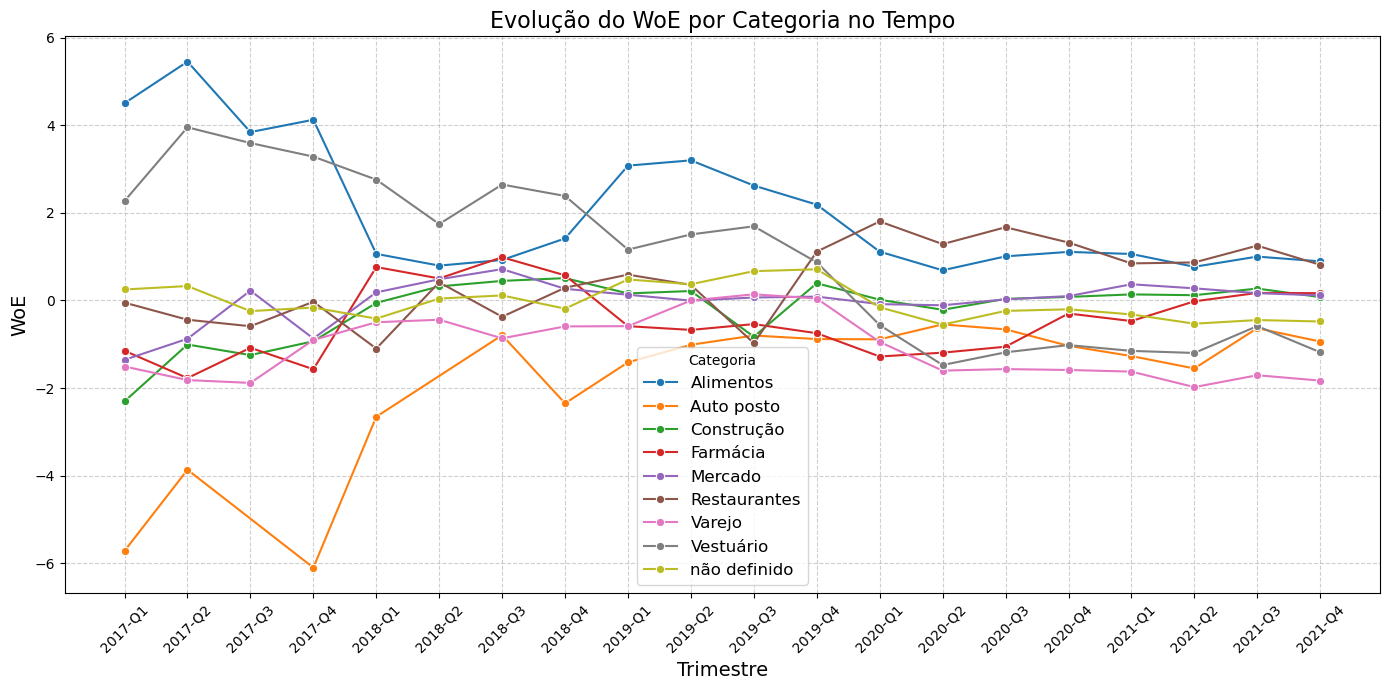

In [89]:
plt.figure(figsize=(14, 7))

# Plotar a tendência do WoE para cada categoria ao longo do tempo
sns.lineplot(
    data=woe_por_tempo_categoria,
    x='Ano_Trimestre',
    y='WoE',
    hue='categoria',
    marker='o'
)

plt.title('Evolução do WoE por Categoria no Tempo', fontsize=16)
plt.xlabel('Trimestre', fontsize=14)
plt.ylabel('WoE', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Categoria', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Anterior ao ano de 2020, temos aqui que Autoposto tinha um WOE muito pequeno em relação às demais variáveis, enquanto que alimento e vestuário eram uma espécie de líderes nesse quesito. A partir de 2020, além de todas apresentarem um WOE mais estável, junto com a categoria Alimentos, tem se destacado também agora a categoria restaurante. 

### <span style="color:red">Análise do Comportamento das Variáveis por Período e Categoria


#### <span style="color:red">*Comportamento Geral ao Longo do Tempo:*
- **Antes de 2020:**  
  Todos os gráficos apresentam comportamento instável para as variáveis analisadas.  
- **A partir de 2020:**  
  O comportamento começa a se tornar mais estável.

#### <span style="color:red">*Quantidade de Notas Registradas:*
- Entre o **3º trimestre de 2017** e o **3º trimestre de 2019**, houve quedas e aumentos bruscos na quantidade de notas registradas.  
- Após esse período, o comportamento voltou a ser semelhante ao início de 2017.

#### <span style="color:red">*Quantidade de Notas por Categoria:*
- **2017 a 2018:**  
  A quantidade de notas da categoria **Restaurante** despencou.  
- **2018 a 2019:**  
  A categoria **Restaurante** apresentou um aumento até o 3º trimestre de 2019, mas despencou novamente após esse período.  
  A partir de 2020, a categoria Restaurante permaneceu entre as 3 categorias com menos registros.  
- **Após 2020:**  
  - A categoria **Mercado** tornou-se a mais frequente.  
  - As categorias seguintes foram: **'Não definido'**, **Construção** e **Farmácia**.  
  - As demais categorias apresentaram menos de 1.000 notas registradas cada.

#### <span style="color:red">*Proporção de Notas com Crédito:*
- **Antes de 2020:**  
  Comportamento altamente instável.  
- **A partir de 2020:**  
  Comportamento mais estável, com as maiores proporções de notas com retorno observadas nas categorias:  
  1. **Restaurante**  
  2. **Alimentos**  
  3. **Mercado**  
  4. **Construção**  
  5. **Farmácia**

#### <span style="color:red">*Análise do Information Value (IV):*
- **2017:**  
  As categorias com maior impacto foram **Mercado**, **Autoposto** e **Construção**.  
- **A partir de 2020:**  
  Com maior estabilização, a categoria **Varejo** passou a apresentar o maior IV, enquanto as demais categorias possuem valores de IV mais próximos.

#### <span style="color:red">*Análise do Weight of Evidence (WoE):*
- A categoria **Alimentos** foi uma das poucas a manter sempre um **WoE positivo**, indicando que a proporção de retorno foi maior que a de não retorno ao longo de todo o período analisado.  
- A categoria **Vestuário** apresentava **WoE positivo antes de 2020**, mas passou a ser **negativo após 2020**.  
- A categoria **Farmácia** teve retorno positivo apenas em 2018 e nos dois últimos trimestres de 2021.  
- A categoria **Restaurante** apresentava **WoE negativo no início do período analisado**, mas entre o **3º e o 4º trimestres de 2019** passou a ter **valores positivos consideráveis**, ultrapassando até mesmo a categoria Alimentos em alguns momentos.  
- A categoria **Mercado** geralmente apresentou proporção de retornos maior que de não retornos, mantendo um WoE frequentemente positivo.

